In [1]:
import pandas as pd
import string
import nltk
from nltk.tokenize import word_tokenize
from nltk.tokenize import sent_tokenize
from sklearn.decomposition import LatentDirichletAllocation as LDA
import numpy as np
import matplotlib.pyplot as plt

Need to load tools from NLTK for stopwords and punctuation

In [2]:
#nltk.download('punkt')
#nltk.download('stopwords')
from nltk.corpus import stopwords
nltk.download('wordnet')
from nltk.stem import WordNetLemmatizer, SnowballStemmer
from nltk.stem.porter import *

[nltk_data] Downloading package wordnet to C:\Users\Mitch
[nltk_data]     Gauthier\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


Prepocessing and cleaning below. First we want to get transcripts into list of strings. Then we will
        1. Tokenize each documnet into sentences
        2. Remove all stop words from sentences
        3. Remove all punctuation from sentences
        4. Lemmatize and Stem each word in the sentences

In [3]:
data = pd.read_csv('mtsamples.csv')
data_cols = data.columns
trans = list(data['transcription'].dropna())
exclude = set(string.punctuation)
stop = set(stopwords.words('english'))
stemmer = SnowballStemmer(language='english')

txt = []
for i in range(0, len(trans)):
        word = word_tokenize(str(trans[i]))
        #Remove stopwords and punctuation
        #Then lemmatize and stem the words
        cle = [w for w in word if not w in exclude]
        words = [c.lower() for c in cle if not c in stop]
        stem = [stemmer.stem(WordNetLemmatizer().lemmatize(w)) for w in words]
        txt.append(' '.join(stem))

 

In [4]:
from sklearn.datasets import fetch_20newsgroups
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import NMF
from gensim.models.coherencemodel import CoherenceModel
from gensim.corpora import Dictionary
from scipy.interpolate import make_interp_spline, BSpline

In [5]:
grams = []
for i in range(0, len(txt)):
    grams.append(word_tokenize(txt[i]))
diction = Dictionary(grams)

In these next two chunks, we will be tokenizing our text data into unigrams and bigrams.

Now we can construct our tf-idf matrices for unigrams.

Below we will transform our matrix to tf_idf format, which will be a term document matrix. Then, this matrix will be decomposed using Nonnegative Matrix Factorization into W * H. Where W are the weights of components and H are the components (i.e. each document is represnted as weighted sum of topics)

In [6]:
#Creating document term matrix - tf-idf
uni_vector = TfidfVectorizer(stop_words='english')
tf_unigram = uni_vector.fit_transform(txt)

#Gathering words present in each document with corresponding term frequency
top_words = np.array(uni_vector.get_feature_names())

#Decomposing tf-idf into matrices W = doc x concept, H = concept x word
nmf = NMF(n_components=20, solver="mu")
W1 = nmf.fit_transform(tf_unigram)
H1 = nmf.components_

uni_topics=[]
for topic in H1:
    uni_topics.append([str(x) for x in top_words[topic.argsort()[-10:]]])

cm = CoherenceModel(topics=uni_topics,texts=grams,dictionary=diction,coherence='c_v')
#cm.get_coherence_per_topic()
cm.get_coherence()

0.7377801554146888

Now that we have decomposed our tf-idf matrix using NMF and generated 20 topics, we need to tune our hyper parameter num_topics to generate the best possible model. For this, we will use perplexity and coherence score over a range of k. Most likely 10 to 30 topics.

The next step is to evaluate the model for a range of components to find which number creates the most optimal model.

Now we will test our model over a wide range of k values and chose the value at the point that precedes diminishing returns

In [7]:
u_plot = []
for i in range(1,30):
    nmat = NMF(n_components=i,solver="mu")
    Wmat = nmat.fit_transform(tf_unigram)
    Hmat = nmat.components_
    unis = []
    for topic in Hmat:
        unis.append([str(x) for x in top_words[topic.argsort()[-10:]]])
    cmod = CoherenceModel(topics=unis,texts=grams,dictionary=diction,coherence='c_v')
    pair = [i,cmod.get_coherence()]
    u_plot.append(pair)

We will now plot number of topics v.s. Coherence Score, and use the elbow method to determine our k value

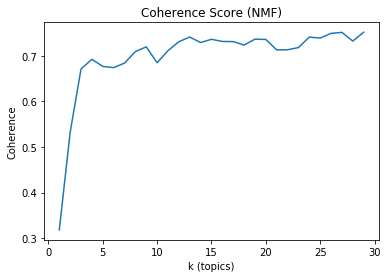

In [8]:
u_plot = np.asarray(u_plot)
plt.title("Coherence Score (NMF)")
plt.ylabel("Coherence")
plt.xlabel("k (topics)")
plt.plot(u_plot[:,0],u_plot[:,1])

We will chose 15 topics, because this is where our graph plateaus. Meaning it is the point where Coherence is maximized and the model is still generalized.

In [10]:
_nmf = NMF(n_components=15,solver="mu")
_W = _nmf.fit_transform(tf_unigram)
_H = _nmf.components_


for i, top in enumerate(_H):
    num = str(i+1)
    print("Topic "+num+": "+', '.join([x for x in top_words[top.argsort()[-10:]]]))

Topic 1: day, time, present, year, past, deni, medic, pain, histori, patient
Topic 2: remov, close, dissect, anesthesia, oper, sutur, incis, use, procedur, place
Topic 3: stenosi, circumflex, branch, aortic, french, right, cathet, left, coronari, arteri
Topic 4: herniat, anterior, plate, c3, disc, c7, cervic, c4, c6, c5
Topic 5: reveal, imag, contrast, tumor, exam, mass, ct, lobe, normal, right
Topic 6: medial, joint, tendon, proxim, osteotomi, plantar, right, ankl, metatars, foot
Topic 7: rectum, esophagus, biopsi, colonoscopi, cecum, patient, procedur, polyp, scope, colon
Topic 8: bag, phacoemulsif, anterior, lid, capsular, intraocular, cataract, chamber, len, eye
Topic 9: tender, neck, intact, equal, mass, nose, clear, negat, ear, normal
Topic 10: vagin, placenta, infant, clamp, cord, cervix, deliveri, uterin, fetal, uterus
Topic 11: nerv, pain, l3, root, needl, disc, lumbar, s1, l4, l5
Topic 12: place, appendix, mm, abdomen, cystic, laparoscop, duct, trocar, port, gallbladd
Topic 1

Above are our optimal topics for the transcripts